### Introduction
The aim of this notebook is to create a machine learning model and transform it into an API which, when given some novel input parameters, returns the model’s prediction.

### The model
The model that is going to be used is a Random Forest model, built using a data set of Titanic passengers (`data/train.csv`). The model looks to predict the probability of whether a passenger would have survived.

### The goal
Input is an API call such as

```
/predict?class=2&sex=male&age=22&sibsp=2&parch=0&title=mr
```

with a response in the form of

```
{ "probabilityOfSurvival": 0.95 }
```

### Creating the model

In [1]:
import pandas as pd

Import the data from the CSV file train.csv.

In [2]:
train = pd.read_csv('data/train.csv')

Explore the data.

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Get the mapping for the gender by creating a function that retrieves the categories of a column of type `category`. This will return a number and its corresponding value.

In [5]:
def _get_category_mapping(column):
    """ Return the mapping of a category """
    return dict([(cat, code) for code, cat in enumerate(column.cat.categories)])

The unique values before converting to a category:

In [6]:
train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [7]:
train['Sex'] = train['Sex'].astype('category')
sex_mapping = _get_category_mapping(train['Sex'])
train['Sex'] = train['Sex'].cat.codes

and the values after converting:

In [8]:
sex_mapping

{'female': 0, 'male': 1}

We will keep the mapping so we can use it later once we deploy the Model as a Service.

In [9]:
train['Sex'].unique()

array([1, 0])

Create categories for the titles by extracting them from the names. 

In [10]:
train['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [11]:
FRENCH_MAPPING = {
    'Mme': 'Mrs',   # Madame
    'Mlle': 'Miss', # Mademoiselle
    'M.': 'Mr',     # Monsieur
}

In [12]:
FINAL_TITLES = [
    'master',
    'miss',
    'mr',
    'mrs'
]

In [13]:
import re
def _extract_title(column):
    """ Extract the title """
    # Remove dots
    title_column = column.apply(lambda x: re.sub(r'(.*, )|(\..*)', '', x).lower()).astype(str)
    # Map the French to English titles
    title_column = title_column.replace(FRENCH_MAPPING)
    # Create the categories based on the final titles and the rare title
    title_column = title_column.apply(lambda x: 'rare title' if x not in FINAL_TITLES else x)
    return title_column

In [14]:
train['Title'] = _extract_title(train['Name'])

In [15]:
train[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",mrs
2,"Heikkinen, Miss. Laina",miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",mrs
4,"Allen, Mr. William Henry",mr


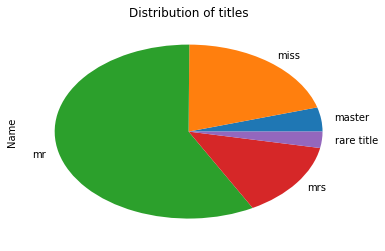

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
train.groupby('Title')['Name'].count().plot.pie(title="Distribution of titles")

Let's now convert the titles to a category as we did for the gender:

In [26]:
train['Title'] = train['Title'].astype("category")
title_mapping = _get_category_mapping(train['Title'])
train['Title'] = train['Title'].cat.codes

In [29]:
title_mapping

{'master': 0, 'miss': 1, 'mr': 2, 'mrs': 3, 'rare title': 4}

Let us now investigate the ages of the people aboard the Titanic.

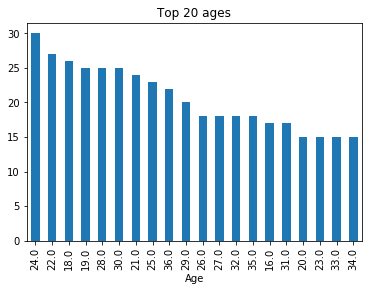

In [17]:
train.groupby('Age')['Name'].count().nlargest(20).plot.bar(title="Top 20 ages")

In [18]:
train[train['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
5,6,0,3,"Moran, Mr. James",1,NaN,0,0,330877,8.4583,NaN,Q,mr
17,18,1,2,"Williams, Mr. Charles Eugene",1,NaN,0,0,244373,13.0000,NaN,S,mr
19,20,1,3,"Masselmani, Mrs. Fatima",0,NaN,0,0,2649,7.2250,NaN,C,mrs
26,27,0,3,"Emir, Mr. Farred Chehab",1,NaN,0,0,2631,7.2250,NaN,C,mr
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",0,NaN,0,0,330959,7.8792,NaN,Q,miss
29,30,0,3,"Todoroff, Mr. Lalio",1,NaN,0,0,349216,7.8958,NaN,S,mr
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",0,NaN,1,0,PC 17569,146.5208,B78,C,mrs
32,33,1,3,"Glynn, Miss. Mary Agatha",0,NaN,0,0,335677,7.7500,NaN,Q,miss
36,37,1,3,"Mamee, Mr. Hanna",1,NaN,0,0,2677,7.2292,NaN,C,mr
42,43,0,3,"Kraeff, Mr. Theodor",1,NaN,0,0,349253,7.8958,NaN,C,mr


In the dataset the age is missing for 177 persons. Use a linear model to calculate the age based on the class, gender and number of siblings/spouses based on the rows __with__ an age.

In [19]:
LIN_MOD_FEATURES = [
    'Pclass',
    'Sex',
    'SibSp'
]

In [20]:
LIN_MOD_TARGET = [
    'Age'
]

In [21]:
from sklearn import linear_model

def _create_linear_model(frame):
    """ Create linear model """
    imput = frame[frame.Age.notnull()]
    features = imput[LIN_MOD_FEATURES]
    target = imput[LIN_MOD_TARGET]
    model = linear_model.LinearRegression()
    model.fit(features, target)
    return model

In [22]:
linear_mod = _create_linear_model(train)

Calculate the predicted age for __all__ the rows:

In [23]:
train['PredictedAge'] = linear_mod.predict(train[LIN_MOD_FEATURES])

Merge the predicted age into the dataframe where there is no age yet:

In [24]:
train['Age'] = train.apply(lambda x: x.Age if pd.notnull(x.Age) else x.PredictedAge, axis=1)

Drop the prediction column since it is not needed anymore:

In [25]:
train.drop(['PredictedAge'], axis=1, inplace=True)

To estimate the chance of survival we will use a Random Forest Classifier.

In [36]:
FEATURES = [
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Title',
]
TARGET = 'Survived'
NUM_TREES = 500
MAX_FEATURES = 2

In [42]:
from sklearn.ensemble import RandomForestClassifier

def _create_random_forest_classifier(frame):
    """ Build a random forest classifier """
    features = frame[FEATURES]
    target = frame[TARGET]
    model = RandomForestClassifier(n_estimators=NUM_TREES,
                                   max_features=MAX_FEATURES,
                                   random_state=754)
    model.fit(features, target)
    return model

In [43]:
random_forest_classifier = _create_random_forest_classifier(train)

As a final step for the _MaaS_ we will save the model and the two mappings to disk. This way we can upload them to the microservice in the next step.

In [40]:
from sklearn.externals import joblib

def _save_variable(variable, filename):
    """ Save a variable to a file """
    joblib.dump(variable, filename)

In [41]:
_save_variable(random_forest_classifier, 'random_forest.mdl')
_save_variable(title_mapping, 'title_mapping.pkl')
_save_variable(sex_mapping, 'sex_mapping.pkl')

## Deploying the model as a service

To deploy the model as a service, I am going to use the web framework Flask. This makes it easy to interact with the variables we saved in the previous step and it is straighforward to create a simple web app with only a few routes. The `app.py` contains all the magic and will be used in the Dockerfile to get the container with the model online. This is the code for the main application:

In [1]:
%%file app.py
#!/usr/bin/env python
# # -*- coding: utf-8 -*-
""" Flask API for predicting probability of survival """
import json
import sys
from flask import Flask, jsonify, request, render_template, url_for
from sklearn.externals import joblib
import numpy as np

try:
    saved_model = joblib.load('random_forest.mdl')
    sex_mapping = joblib.load('sex_mapping.pkl')
    title_mapping = joblib.load('title_mapping.pkl')
except:
    print("Error loading application. Please run `python create_random_forest.py` first!")
    sys.exit(0)

app = Flask(__name__)

@app.route('/')
def main():
    """ Main page of the API """
    return "This is the main page"

@app.route('/predict', methods=['GET'])
def predict():
    """ Predict the probability of survival """
    args = request.args
    required_args = ['class', 'sex', 'age', 'sibsp', 'parch', 'title']
    # Simple error handling for the arguments
    diff = set(required_args).difference(set(args.keys()))
    if len(diff) > 0:
        return "Error: wrong arguments. Missing arguments {}".format(str(diff))
    person_features = np.array([args['class'],
                                sex_mapping[args['sex']],
                                args['age'],
                                args['sibsp'],
                                args['parch'],
                                title_mapping[args['title'].lower()]
                               ]).reshape(1, -1)
    probability = saved_model.predict_proba(person_features)[:, 1][0]
    return jsonify({'probabilityOfSurvival': probability})

if __name__ == '__main__':
    app.run(host='0.0.0.0')

Overwriting app.py


#### Breakdown

The first bit

```python
try:
    saved_model = joblib.load('random_forest.mdl')
    sex_mapping = joblib.load('sex_mapping.pkl')
    title_mapping = joblib.load('title_mapping.pkl')
except:
    print("Error loading application. Please run `python create_random_forest.py` first!")
    sys.exit(0)
```

will import the three variables that we saved during training the model. We can use the mappings to map the input arguments of the API to the proper fields of the model.

The next part is default for a Flask application:

```python
app = Flask(__name__)

@app.route('/')
def main():
    """ Main page of the API """
    return "This is the main page"
```

The predict route is slightly more advanced. It will take parameters using the GET method and verify if all six required arguments are present. 

```python
args = request.args
required_args = ['class', 'sex', 'age', 'sibsp', 'parch', 'title']
# Simple error handling for the arguments
diff = set(required_args).difference(set(args.keys()))
if len(diff) > 0:
    return "Error: wrong arguments. Missing arguments {}".format(str(diff))
```

If all arguments are present, it will create a feature array to feed to the prediction model by using `numpy`. This is where the mappings come in, as an input for the title we have a string, but this is mapped to the corresponding index of the mapping to match to the feature in the model. 

```python
person_features = np.array([args['class'],
                            sex_mapping[args['sex']],
                            args['age'],
                            args['sibsp'],
                            args['parch'],
                            title_mapping[args['title'].lower()]
                           ]).reshape(1, -1)
```

Finally the probability is calculated based on the features and the probability is fed back using a JSON object.

```python
probability = saved_model.predict_proba(person_features)[:, 1][0]
return jsonify({'probabilityOfSurvival': probability})
```

The last bit of `app.py` is the default way of starting the Flask server. I have modified the host from `localhost` to `0.0.0.0` in order to be able to access the API from any IP address.

```python
app.run(host='0.0.0.0')
```

#### Docker
To run the model as a service, I will use Docker to create a container where the server is running and the endpoint for the prediction is exposed. The `Dockerfile` is very basic. It will use Python 3, copy the contents to the container, install the requirements and start the server.

```Dockerfile
# Base image
FROM python:3
# Copy contents
COPY . /app
# Change work directory
WORKDIR /app
# Install the requirements
RUN pip install -r requirements.txt
# Start the application
CMD ["python", "app.py"]
```

where `requirements.txt` contains the following:

```
certifi==2018.1.18
click==6.7
Flask==0.12.2
itsdangerous==0.24
Jinja2==2.10
MarkupSafe==1.0
numpy==1.14.0
pandas==0.22.0
python-dateutil==2.6.1
pytz==2017.3
scikit-learn==0.19.1
scipy==1.0.0
six==1.11.0
Werkzeug==0.14.1
```

The `docker-compose.yml` will simply build the current `Dockerfile` and expose port 5000.

```
version: '2'
services:
  flask:
    build: .
    ports:
      - "5000:5000"
```

Running `docker-compose up -d` in this folder will now start the server and by going to the IP of the machine the endpoint should be visible on port 5000 and route `predict`.

#### Execution
Let's put it to the test: create the files, spin up Docker and check the API response.

In [45]:
%%file Dockerfile
# Base image
FROM python:3
# Copy contents
COPY . /app
# Change work directory
WORKDIR /app
# Install the requirements
RUN pip install -r requirements.txt
# Start the application
CMD ["python", "app.py"]

Writing Dockerfile


In [46]:
%%file requirements.txt
certifi==2018.1.18
click==6.7
Flask==0.12.2
itsdangerous==0.24
Jinja2==2.10
MarkupSafe==1.0
numpy==1.14.0
pandas==0.22.0
python-dateutil==2.6.1
pytz==2017.3
scikit-learn==0.19.1
scipy==1.0.0
six==1.11.0
Werkzeug==0.14.1

Writing requirements.txt


In [47]:
%%file docker-compose.yml
version: '2'
services:
  flask:
    build: .
    ports:
      - "5000:5000"

Writing docker-compose.yml


In [51]:
!docker-compose up -d


Compose does not use swarm mode to deploy services to multiple nodes in a swarm. All containers will be scheduled on the current node.

To deploy your application across the swarm, use `docker stack deploy`.

Building flask
Step 1/5 : FROM python:3
3: Pulling from library/python








Digest: sha256:18e515f2cd7fd40c019bce12fda36b9a9c58613cf6fb8d6e58f831ef565a7b81
Status: Downloaded newer image for python:3
 ---> d69bc9d9b016
Step 2/5 : COPY . /app
 ---> b97435c40d8d
Step 3/5 : WORKDIR /app
Removing intermediate container 15515f492696
 ---> 277d4cd7e786
Step 4/5 : RUN pip install -r requirements.txt
 ---> Running in ba1465b7f6e3
  Running setup.py bdist_wheel for itsdangerous: started
  Running setup.py bdist_wheel for itsdangerous: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/2c/4a/61/5599631c1554768c6290b08c02c72d7317910374ca602ff1e5
  Running setup.py bdist_wheel for MarkupSafe: started
  Running setup.py bdist_wheel for MarkupSafe: finished with stat

In [53]:
!docker ps | grep flask

5e7d954d4215        notebooks_flask                    "python app.py"          19 minutes ago      Up 19 minutes          0.0.0.0:5000->5000/tcp             notebooks_flask_1


#### Verification
The following code will call the API with some parameters and print the result. 

In [55]:
import requests

params = {
    'class': 2,
    'age': 22,
    'sibsp': 2,
    'parch': 0,
    'title': 'mr',
    'sex': 'male',
}

url = 'http://hub.jitsejan.com:5000/predict'
r = requests.get(url, params)
print(r.url)
print(r.json())

http://hub.jitsejan.com:5000/predict?class=2&age=22&sibsp=2&parch=0&title=mr&sex=male
{'probabilityOfSurvival': 0.006333333333333333}


And that is it. The JSON object can now be returned to the front-end of the web application and be displayed in a fancy way, but that is outside the scope of this notebook.

Let's clean up by retrieving the Docker ID and removing the container.

In [57]:
!docker stop $(docker ps -aqf "name=flask")

5e7d954d4215


In [58]:
!docker rm $(docker ps -aqf "name=flask")

5e7d954d4215
